In [2]:
# In Notebooks/main.ipynb
import sys
import os
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
from load_data import MovieLensDataLoader

MOVIELENS_DIR = "/Users/timeless/Downloads/data/"

loader = MovieLensDataLoader(data_path=MOVIELENS_DIR)

# Load the data
movies, ratings, tags, links = loader.load_data()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
ratings['user_id'] = ratings['user_id'].values.astype(np.int32)
print("Data types of the ratings dataframe:")
print(ratings.dtypes)

Data loaded successfully!
Data types of the ratings dataframe:
Unnamed: 0      int64
user_id         int32
movie_id        int64
rating        float32
dtype: object


,Unnamed: 0,movie_id,imdb_id,tmdb_id
0,0,1,114709,862.0
1,1,2,113497,8844.0
2,2,3,113228,15602.0
3,3,4,114885,31357.0
4,4,5,113041,11862.0


In [ ]:
# Plot a bar chart of the ratings
import matplotlib.pyplot as plt
plt.style.use("dark_background")
ratings['rating'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.title('Distribution of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.show()

In [ ]:
# Plot only top 20 most rated movies
top_movies = ratings["movie_id"].value_counts().head(20).index
filtered_movies = movies[movies["movie_id"].isin(top_movies)]
plt.barh(filtered_movies["title"], filtered_movies["movie_id"], color="coral")

In [ ]:
# Plot the number of ratings per movie
plt.figure()
ratings_per_movie = ratings["movie_id"].value_counts()
plt.hist(ratings_per_movie, bins=30, color="coral")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.title("Number of Ratings per Movie")
plt.show()

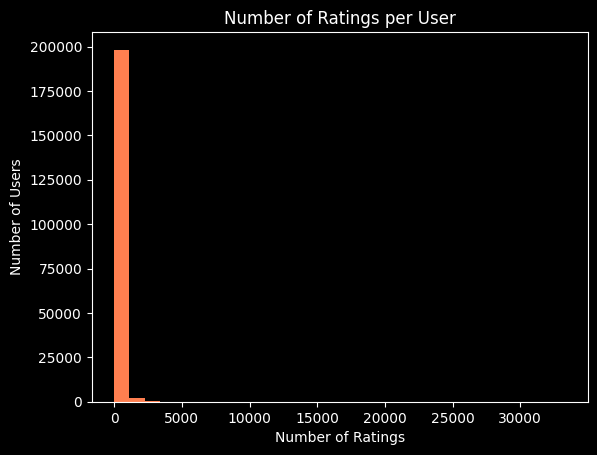

In [6]:
# Plot the number of ratings per user
plt.figure()
ratings_per_user = ratings["user_id"].value_counts()
plt.hist(ratings_per_user, bins=30, color="coral")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.title("Number of Ratings per User")
plt.show()

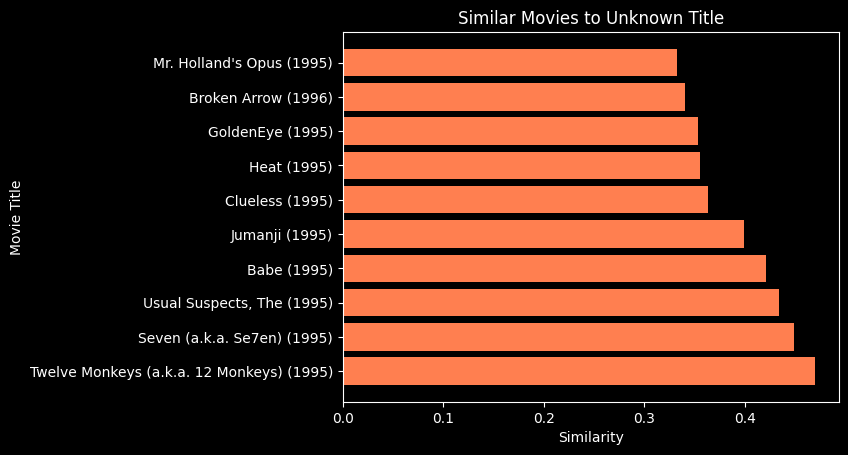

In [7]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

# Encode user and movie IDs
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings["user_id"] = user_encoder.fit_transform(ratings["user_id"])
ratings["movie_id"] = movie_encoder.fit_transform(ratings["movie_id"])

# Create a user-movie sparse matrix
user_movie_matrix = csr_matrix(
    (ratings["rating"], (ratings["user_id"], ratings["movie_id"]))
)

# Calculate cosine similarities for a limited set of movies
n_movies = 100  # You can adjust the number to improve performance
user_movie_matrix_subset = user_movie_matrix[
    :, :n_movies
]  # Taking only a subset of movies
similarities = cosine_similarity(user_movie_matrix_subset.T, dense_output=False)

# Pre-store titles for faster lookup
movie_titles = movies.set_index("movie_id")["title"].to_dict()


# Function to get top N similar movies
def get_similar_movies(movie_id, n=10):
    similar_indices = (
        similarities[movie_id].toarray().ravel().argsort()[::-1][1 : n + 1]
    )
    return [
        (movie_encoder.inverse_transform([i])[0], similarities[movie_id, i])
        for i in similar_indices
    ]


# Choose a random movie from the subset and plot
random_movie_id = random.choice(range(n_movies))
movie_title = movie_titles.get(random_movie_id, "Unknown Title")
similar = get_similar_movies(random_movie_id)
similar_titles = [
    movie_titles.get(movie_id, "Unknown Title") for movie_id, _ in similar
]
similar_scores = [score for _, score in similar]

plt.barh(similar_titles, similar_scores, color="coral")
plt.xlabel("Similarity")
plt.ylabel("Movie Title")
plt.title(f"Similar Movies to {movie_title}")
plt.show()